In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
k_fold = 10
seed = 42
np.random.seed(seed)

In [9]:
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

In [10]:
def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data
def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

#### 1 Read and describe data

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z']
Number of rows: 1299 
Number of columns: 28

Labels: 
label
U    596
M    448
D    255
Name: count, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: object)


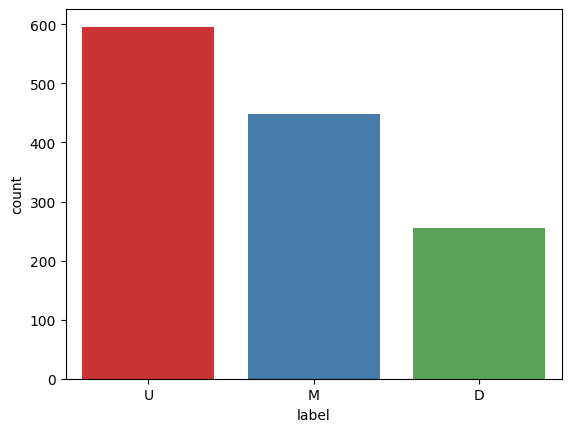

In [11]:
df = describe_dataset('train_front_clean.csv')
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "D", "label"] = 0
df.loc[df["label"] == "M", "label"] = 1
df.loc[df["label"] == "U", "label"] = 2

## Phân chia dữ liệu

### Chia dữ liệu

In [12]:
X = df.drop("label", axis=1)
y = df["label"].astype("int")

In [7]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

### Thử nghiệm các mô hình

In [8]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=repeated_stratify_cv, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.8139455376664678
SVC: 0.8360226595110315
KNN: 0.7970264360962035
DTC: 0.8183283641423176
SGDC: 0.7690578413834228
NB: 0.7900894454382826
RF: 0.8852951699463326


### Thử nghiệm lại preprocessor

In [9]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list()

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
X = transformed_X
X

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_hip_x,...,left_knee_z,right_knee_x,right_knee_y,right_knee_z,left_ankle_x,left_ankle_y,left_ankle_z,right_ankle_x,right_ankle_y,right_ankle_z
0,0.076132,-0.543366,0.923471,-1.330812,-0.550524,0.607384,1.336343,-0.577599,0.604656,-1.312474,...,0.586313,1.124221,0.994270,0.501558,-0.786402,0.926304,-0.112782,0.803989,0.948874,-0.207909
1,0.072961,-0.509547,0.652409,-1.046052,-0.518003,0.173997,1.305214,-0.546445,0.252631,-1.144646,...,0.359932,0.801011,0.705514,0.293538,-0.595738,0.614424,-0.053819,0.999464,0.685515,-0.110590
2,0.774998,-0.564729,0.911838,-0.978407,-0.536290,0.764784,1.598911,-0.515206,0.412823,-1.267943,...,0.783554,0.959448,0.795532,0.582687,-0.747275,0.639382,0.077002,0.901809,0.708368,-0.097322
3,0.102852,-0.566938,0.768231,-1.451928,-0.534129,0.539640,1.288680,-0.607610,0.312964,-1.340549,...,0.598684,1.066355,0.944774,0.489436,-0.966419,0.880243,-0.026431,0.720534,0.914218,-0.146848
4,1.230970,-0.611040,0.768929,-0.834153,-0.500981,0.395541,1.820190,-0.604424,0.289068,-1.284661,...,0.645330,0.906858,0.825614,0.535668,-1.142209,0.837160,-0.055268,0.550732,0.803919,-0.153272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,0.567324,0.859122,0.838297,-0.646597,0.259126,0.567575,0.742453,0.235273,0.428575,-1.082206,...,-0.735325,0.530860,-0.576248,-0.677218,-0.550408,-0.575565,-1.111380,0.782489,-0.581638,-1.107156
1295,-0.156354,0.826722,0.285354,-0.614326,0.158326,0.262137,0.752520,0.129471,0.206167,-0.960123,...,-1.044569,0.267680,-0.964518,-1.006073,-0.856537,-0.115118,-1.528801,0.872812,-0.251475,-1.500895
1296,-0.264624,1.233396,0.473096,-1.053539,1.073767,0.155123,1.134018,1.167582,0.330421,-1.417919,...,-0.581327,0.186560,-1.065662,-0.707943,-1.156060,-1.032022,-1.448301,0.623094,-0.995051,-1.443182
1297,-0.322943,0.885955,0.648308,-0.550479,0.245400,0.570741,0.906488,0.049682,0.485047,-1.038094,...,-1.054120,-0.141234,-1.448365,-0.896786,-0.828128,-0.562988,-1.466281,0.851001,-0.840287,-1.413460


# Chọn bộ tham số

#### Dùng GridSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

In [ ]:
best_params_grid = {}
models_tuned_grid = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ("SVC", SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    },
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}

# Grid Search application with check for parameter grid existence
for name, model in models.items():
    print("Model processing: ", name)
    if name in param_grid:
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid[name], 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,  # Sử dụng tất cả các lõi CPU để tăng tốc quá trình
            verbose=1  # Hiển thị tiến trình trong quá trình tìm kiếm
        )
        grid_search.fit(X_train, y_train)
        best_params_grid[name] = grid_search.best_params_
        models_tuned_grid[name] = grid_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params1.json', 'w') as f:
    json.dump(best_params_grid, f)

In [ ]:
# Printing the best parameters for each model
print("Best parameters for each model:")
for name, params in best_params_grid.items():
    print(f"{name}: {params}")

# Printing the tuned models
print("\nTuned models:")
for name, model in models_tuned_grid.items():
    print(f"{name}: {model}")


#### Dùng RandomizedSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

##### SVC

In [ ]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

##### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


##### Các thuật toán khác

In [ ]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


#### Thử nghiệm bộ tham số

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
with open('best_params_front.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(**best_params.get("SGDC", {})))),
    ("NB", GaussianNB()),  # GaussianNB không có tham số cụ thể để điều chỉnh
    ('RF', RandomForestClassifier(**best_params.get("RF", {}), random_state=42)),
]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    a_score = accuracy_score(y_test, model_results)
    final_results.append((name, a_score))

# Sort results by accuracy score
final_results.sort(key=lambda k: k[1], reverse=True)

pd.DataFrame(final_results, columns=["Model", "Accuracy score"])


,Model,Accuracy score
0,RF,0.873077
1,SVC,0.850000
2,KNN,0.830769
3,LR,0.811538
4,SGDC,0.803846
5,NB,0.780769
6,DTC,0.773077


##### SVC

In [29]:
with open('best_params_front/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
svc_model = SVC(probability=True, **best_params.get("SVC", {}), random_state=42)
svc_model.fit(X_train, y_train)

# Lưu mô hình vào file
with open('best_models/SVC_model_front.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

##### Random forest

In [30]:
with open('best_params_front/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)
rf_model.fit(X_train, y_train)

# Lưu mô hình vào file
with open('best_models/RF_model_front.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

#### Các thuật toán khác: LR, KNN, DTC

In [22]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.849428463760834
KNN: 0.8212319146749494
DTC: 0.8207271813728291


#### Dự đoán thử nghiệm

In [88]:
def load_model(model_filename):
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

# Example of loading the Logistic Regression model
loaded_lr_model = load_model('best_models/SVC_model_side.pkl')

In [89]:
predictions = loaded_lr_model.predict(X_test)
predictions

array([1, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 2, 1, 0, 0,
       1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2,
       1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1,
       1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 1, 2, 0, 2,
       1, 0, 1, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2,
       1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0,
       0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2,

In [90]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Optionally, add a column to check if the predictions match the actual values
comparison_df['Match'] = comparison_df['Actual'] == comparison_df['Predicted']

# Display the DataFrame
print(comparison_df)

      Actual  Predicted  Match
1280       1          1   True
29         2          2   True
210        2          2   True
1730       0          0   True
584        2          2   True
...      ...        ...    ...
1894       0          1  False
1080       1          1   True
962        1          1   True
1606       1          0  False
1285       1          1   True

[419 rows x 3 columns]


In [91]:
# Calculate the percentage of matches
match_rate = comparison_df['Match'].mean() * 100
print(f"Percentage of Correct Predictions: {match_rate:.2f}%")


Percentage of Correct Predictions: 91.89%
